In [43]:
import soundfile # to read audio file
import numpy as np
import pandas as pd
import librosa # to extract speech features
import glob
import os
import pickle 
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split 

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import plot_model, to_categorical

In [44]:
def extract_feature(file_name, **kwargs):
    """
    Extract feature from audio file `file_name`
        Features supported:
            - MFCC (mfcc)
            - Chroma (chroma)
            - MEL Spectrogram Frequency (mel)
            - Contrast (contrast)
            - Tonnetz (tonnetz)
        e.g:
        `features = extract_feature(path, mel=True, mfcc=True)`
    """
    mfcc = kwargs.get("mfcc")
    chroma = kwargs.get("chroma")
    mel = kwargs.get("mel")
    contrast = kwargs.get("contrast")
    tonnetz = kwargs.get("tonnetz")
    with soundfile.SoundFile(file_name) as sound_file:
        X = sound_file.read(dtype="float32")
        if (len(X.shape) != 1):
            if (X.shape[1] == 2):
                X = X[:,0]
            else:
                return [None]
        sample_rate = sound_file.samplerate
        if chroma or contrast:
            stft = np.abs(librosa.stft(X))
        result = np.array([])
        if mfcc:
            mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T, axis=0)
            result = np.hstack((result, mfccs))
        if chroma:
            chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T,axis=0)
            result = np.hstack((result, chroma))
        if mel:
            mel = np.mean(librosa.feature.melspectrogram(X, sr=sample_rate).T,axis=0)
            result = np.hstack((result, mel))
        if contrast:
            contrast = np.mean(librosa.feature.spectral_contrast(S=stft, sr=sample_rate).T,axis=0)
            result = np.hstack((result, contrast))
        if tonnetz:
            tonnetz = np.mean(librosa.feature.tonnetz(y=librosa.effects.harmonic(X), sr=sample_rate).T,axis=0)
            result = np.hstack((result, tonnetz))
    return result

In [70]:
## codes in data
int2emotion = {
    "01": "neutral",
    "02": "calm",
    "03": "happy",
    "04": "sad",
    "05": "angry",
    "06": "fearful",
    "07": "disgust",
    "08": "surprised"
}

# only files with these emotion labels are used
emotions_dict ={
    "neutral": 0,
    "happy": 1,
    "angry": 2,
    "surprised": 3
}

category_to_emotion = {}

for key in emotions_dict.keys():
    value = emotions_dict[key]
    category_to_emotion[value] = key

In [71]:
def load_data(test_size=0.2, max_amount=10000):
    i = 0
    X, y = [], []
    amount = 0
    for file in glob.glob("ravdess/Audio*/Actor_*/*.wav"):
        if (amount >= max_amount):
            break
        
        basename = os.path.basename(file)
        
        emotion = int2emotion[basename.split("-")[2]]
        allowed_emotions = emotions_dict.keys()
        
        if emotion not in allowed_emotions:
            continue
        emotion_category = emotions_dict[emotion]
        
        features = extract_feature(file, mfcc=True, mel=True)
        
        ## there seems to be some unusable data so lets get rid of those
        if (features[0] == None):
            continue
        
        
            
        X.append(features)
        y.append(emotion_category)
        amount = amount + 1
        
    return train_test_split(np.array(X), y, test_size=test_size, random_state=7)

In [72]:
max_amount_of_data = 100000
X_train, X_test, y_train, y_test = load_data(test_size=0.25, max_amount=max_amount_of_data)

In [73]:
X_train = X_train.astype(np.float32)
X_test = X_test.astype(np.float32)


y_train = np.asarray(y_train)
y_train = y_train.astype(np.float32)
y_test = np.asarray(y_test)
y_test = y_test.astype(np.float32)

nb_classes = len(emotions_dict.keys())
y_train = to_categorical(y_train, nb_classes)
y_test = to_categorical(y_test, nb_classes)

In [74]:
print("[+] Number of training samples:", X_train.shape[0])
print("[+] Train shape", X_train.shape)
# number of samples in testing data
print("[+] Number of testing samples:", X_test.shape[0])
# number of features used
# this is a vector of features extracted 
# using extract_features() function
print("[+] Number of features:", X_train.shape[1])


[+] Number of training samples: 504
[+] Train shape (504, 168)
[+] Number of testing samples: 168
[+] Number of features: 168


In [75]:
print("[+] X_train first value's first 5 values", X_train[0][0:5])
print("[+] y_train first value", y_train[0])

[+] X_train first value's first 5 values [-429.91245    47.63481   -19.548073    7.647203  -11.776189]
[+] y_train first value [0. 0. 1. 0.]


# Data for pitch session

### Training the model

In [76]:
x_traincnn = np.expand_dims(X_train, axis=2)
x_testcnn = np.expand_dims(X_test, axis=2)

### Build the model

In [77]:
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from tensorflow.keras.utils import to_categorical
from keras.layers import Input, Flatten, Dropout, Activation
from keras.layers import Conv1D, MaxPooling1D
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from tensorflow.keras import optimizers

model = Sequential()

model.add(Conv1D(128, 5,padding='same',
                 input_shape=(168,1)))
model.add(Activation('relu'))
model.add(Dropout(0.15))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Conv1D(128, 5,padding='same',))
model.add(Activation('relu'))
model.add(Dropout(0.15))
model.add(Flatten())
model.add(Dense(4))
model.add(Activation('softmax'))
opt = optimizers.RMSprop(learning_rate=0.00005, rho=0.9, epsilon=None, decay=0.0)

model.summary()

model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])


cnnhistory=model.fit(x_traincnn, y_train, batch_size=64, epochs=1000, validation_data=(x_testcnn, y_test))

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_12 (Conv1D)           (None, 168, 128)          768       
_________________________________________________________________
activation_18 (Activation)   (None, 168, 128)          0         
_________________________________________________________________
dropout_14 (Dropout)         (None, 168, 128)          0         
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, 21, 128)           0         
_________________________________________________________________
conv1d_13 (Conv1D)           (None, 21, 128)           82048     
_________________________________________________________________
activation_19 (Activation)   (None, 21, 128)           0         
_________________________________________________________________
dropout_15 (Dropout)         (None, 21, 128)          

Epoch 47/1000
8/8 [==============================] - 0s 14ms/step - loss: 1.5892 - accuracy: 0.4067 - val_loss: 1.1281 - val_accuracy: 0.5298
Epoch 48/1000
8/8 [==============================] - 0s 15ms/step - loss: 1.5117 - accuracy: 0.4147 - val_loss: 1.1639 - val_accuracy: 0.4583
Epoch 49/1000
8/8 [==============================] - 0s 16ms/step - loss: 1.4852 - accuracy: 0.4048 - val_loss: 1.1376 - val_accuracy: 0.5595
Epoch 50/1000
8/8 [==============================] - 0s 17ms/step - loss: 1.6132 - accuracy: 0.3968 - val_loss: 1.0855 - val_accuracy: 0.5893
Epoch 51/1000
8/8 [==============================] - 0s 16ms/step - loss: 1.5014 - accuracy: 0.3968 - val_loss: 1.0919 - val_accuracy: 0.5417
Epoch 52/1000
8/8 [==============================] - 0s 18ms/step - loss: 1.5438 - accuracy: 0.4226 - val_loss: 1.1016 - val_accuracy: 0.5357
Epoch 53/1000
8/8 [==============================] - 0s 14ms/step - loss: 1.4352 - accuracy: 0.4524 - val_loss: 1.1073 - val_accuracy: 0.5298
Epoch 

8/8 [==============================] - 0s 16ms/step - loss: 1.1038 - accuracy: 0.4881 - val_loss: 1.0652 - val_accuracy: 0.5357
Epoch 105/1000
8/8 [==============================] - 0s 14ms/step - loss: 1.0920 - accuracy: 0.5218 - val_loss: 1.0488 - val_accuracy: 0.5714
Epoch 106/1000
8/8 [==============================] - 0s 13ms/step - loss: 1.0919 - accuracy: 0.5079 - val_loss: 1.0833 - val_accuracy: 0.5238
Epoch 107/1000
8/8 [==============================] - 0s 14ms/step - loss: 1.0736 - accuracy: 0.5496 - val_loss: 1.0518 - val_accuracy: 0.5833
Epoch 108/1000
8/8 [==============================] - 0s 15ms/step - loss: 1.0610 - accuracy: 0.5238 - val_loss: 1.0870 - val_accuracy: 0.4821
Epoch 109/1000
8/8 [==============================] - 0s 16ms/step - loss: 1.0706 - accuracy: 0.5079 - val_loss: 1.0670 - val_accuracy: 0.5417
Epoch 110/1000
8/8 [==============================] - 0s 16ms/step - loss: 1.0693 - accuracy: 0.5377 - val_loss: 1.0439 - val_accuracy: 0.5833
Epoch 111/1000

8/8 [==============================] - 0s 14ms/step - loss: 0.9638 - accuracy: 0.5694 - val_loss: 0.9808 - val_accuracy: 0.5833
Epoch 162/1000
8/8 [==============================] - 0s 16ms/step - loss: 0.9578 - accuracy: 0.5734 - val_loss: 0.9855 - val_accuracy: 0.5833
Epoch 163/1000
8/8 [==============================] - 0s 17ms/step - loss: 0.9431 - accuracy: 0.5794 - val_loss: 1.0045 - val_accuracy: 0.5774
Epoch 164/1000
8/8 [==============================] - 0s 15ms/step - loss: 0.9537 - accuracy: 0.5595 - val_loss: 0.9928 - val_accuracy: 0.5774
Epoch 165/1000
8/8 [==============================] - 0s 15ms/step - loss: 0.9464 - accuracy: 0.5754 - val_loss: 0.9840 - val_accuracy: 0.5714
Epoch 166/1000
8/8 [==============================] - 0s 13ms/step - loss: 0.9684 - accuracy: 0.5516 - val_loss: 0.9944 - val_accuracy: 0.5714
Epoch 167/1000
8/8 [==============================] - 0s 16ms/step - loss: 0.9298 - accuracy: 0.5794 - val_loss: 0.9909 - val_accuracy: 0.5476
Epoch 168/1000

8/8 [==============================] - 0s 17ms/step - loss: 0.8841 - accuracy: 0.6270 - val_loss: 0.9264 - val_accuracy: 0.6190
Epoch 219/1000
8/8 [==============================] - 0s 16ms/step - loss: 0.8673 - accuracy: 0.6111 - val_loss: 0.9388 - val_accuracy: 0.6190
Epoch 220/1000
8/8 [==============================] - 0s 15ms/step - loss: 0.8644 - accuracy: 0.6290 - val_loss: 0.9373 - val_accuracy: 0.6131
Epoch 221/1000
8/8 [==============================] - 0s 16ms/step - loss: 0.8723 - accuracy: 0.6290 - val_loss: 0.9312 - val_accuracy: 0.6012
Epoch 222/1000
8/8 [==============================] - 0s 17ms/step - loss: 0.8601 - accuracy: 0.6131 - val_loss: 0.9316 - val_accuracy: 0.6071
Epoch 223/1000
8/8 [==============================] - 0s 15ms/step - loss: 0.8750 - accuracy: 0.6091 - val_loss: 0.9242 - val_accuracy: 0.6012
Epoch 224/1000
8/8 [==============================] - 0s 14ms/step - loss: 0.8792 - accuracy: 0.6071 - val_loss: 0.9212 - val_accuracy: 0.6310
Epoch 225/1000

8/8 [==============================] - 0s 15ms/step - loss: 0.7822 - accuracy: 0.6746 - val_loss: 0.8839 - val_accuracy: 0.6488
Epoch 276/1000
8/8 [==============================] - 0s 15ms/step - loss: 0.8163 - accuracy: 0.6349 - val_loss: 0.8983 - val_accuracy: 0.6071
Epoch 277/1000
8/8 [==============================] - 0s 14ms/step - loss: 0.7971 - accuracy: 0.6825 - val_loss: 0.8994 - val_accuracy: 0.6071
Epoch 278/1000
8/8 [==============================] - 0s 14ms/step - loss: 0.8025 - accuracy: 0.6567 - val_loss: 0.9201 - val_accuracy: 0.5774
Epoch 279/1000
8/8 [==============================] - 0s 15ms/step - loss: 0.8271 - accuracy: 0.6488 - val_loss: 0.9011 - val_accuracy: 0.6071
Epoch 280/1000
8/8 [==============================] - 0s 14ms/step - loss: 0.8071 - accuracy: 0.6488 - val_loss: 0.9170 - val_accuracy: 0.6012
Epoch 281/1000
8/8 [==============================] - 0s 15ms/step - loss: 0.7989 - accuracy: 0.6607 - val_loss: 0.8796 - val_accuracy: 0.6488
Epoch 282/1000

8/8 [==============================] - 0s 12ms/step - loss: 0.7836 - accuracy: 0.6667 - val_loss: 0.8554 - val_accuracy: 0.6429
Epoch 333/1000
8/8 [==============================] - 0s 17ms/step - loss: 0.7457 - accuracy: 0.6964 - val_loss: 0.8657 - val_accuracy: 0.6310
Epoch 334/1000
8/8 [==============================] - 0s 18ms/step - loss: 0.7706 - accuracy: 0.6806 - val_loss: 0.8724 - val_accuracy: 0.6190
Epoch 335/1000
8/8 [==============================] - 0s 19ms/step - loss: 0.7809 - accuracy: 0.6687 - val_loss: 0.8660 - val_accuracy: 0.6190
Epoch 336/1000
8/8 [==============================] - 0s 18ms/step - loss: 0.7530 - accuracy: 0.6825 - val_loss: 0.8695 - val_accuracy: 0.6250
Epoch 337/1000
8/8 [==============================] - 0s 16ms/step - loss: 0.7373 - accuracy: 0.6925 - val_loss: 0.8634 - val_accuracy: 0.6310
Epoch 338/1000
8/8 [==============================] - 0s 15ms/step - loss: 0.7473 - accuracy: 0.6885 - val_loss: 0.8551 - val_accuracy: 0.6310
Epoch 339/1000

8/8 [==============================] - 0s 15ms/step - loss: 0.7321 - accuracy: 0.7024 - val_loss: 0.8506 - val_accuracy: 0.6429
Epoch 390/1000
8/8 [==============================] - 0s 17ms/step - loss: 0.7163 - accuracy: 0.7103 - val_loss: 0.8443 - val_accuracy: 0.6429
Epoch 391/1000
8/8 [==============================] - 0s 15ms/step - loss: 0.7222 - accuracy: 0.6806 - val_loss: 0.8681 - val_accuracy: 0.6190
Epoch 392/1000
8/8 [==============================] - 0s 14ms/step - loss: 0.7317 - accuracy: 0.6925 - val_loss: 0.8456 - val_accuracy: 0.6310
Epoch 393/1000
8/8 [==============================] - 0s 15ms/step - loss: 0.7345 - accuracy: 0.6885 - val_loss: 0.8458 - val_accuracy: 0.6369
Epoch 394/1000
8/8 [==============================] - 0s 14ms/step - loss: 0.7273 - accuracy: 0.7063 - val_loss: 0.8480 - val_accuracy: 0.6071
Epoch 395/1000
8/8 [==============================] - 0s 15ms/step - loss: 0.7067 - accuracy: 0.7222 - val_loss: 0.8686 - val_accuracy: 0.6131
Epoch 396/1000

8/8 [==============================] - 0s 13ms/step - loss: 0.6786 - accuracy: 0.7321 - val_loss: 0.8423 - val_accuracy: 0.6250
Epoch 447/1000
8/8 [==============================] - 0s 13ms/step - loss: 0.6924 - accuracy: 0.7262 - val_loss: 0.8620 - val_accuracy: 0.6071
Epoch 448/1000
8/8 [==============================] - 0s 13ms/step - loss: 0.6831 - accuracy: 0.7361 - val_loss: 0.8359 - val_accuracy: 0.6012
Epoch 449/1000
8/8 [==============================] - 0s 15ms/step - loss: 0.6878 - accuracy: 0.7321 - val_loss: 0.8551 - val_accuracy: 0.6012
Epoch 450/1000
8/8 [==============================] - 0s 15ms/step - loss: 0.6989 - accuracy: 0.7123 - val_loss: 0.8254 - val_accuracy: 0.6369
Epoch 451/1000
8/8 [==============================] - 0s 14ms/step - loss: 0.6670 - accuracy: 0.7341 - val_loss: 0.8121 - val_accuracy: 0.6429
Epoch 452/1000
8/8 [==============================] - 0s 13ms/step - loss: 0.6787 - accuracy: 0.7163 - val_loss: 0.8255 - val_accuracy: 0.6369
Epoch 453/1000

8/8 [==============================] - 0s 16ms/step - loss: 0.6525 - accuracy: 0.7321 - val_loss: 0.8073 - val_accuracy: 0.6488
Epoch 504/1000
8/8 [==============================] - 0s 14ms/step - loss: 0.6396 - accuracy: 0.7401 - val_loss: 0.8238 - val_accuracy: 0.6369
Epoch 505/1000
8/8 [==============================] - 0s 16ms/step - loss: 0.6528 - accuracy: 0.7262 - val_loss: 0.8086 - val_accuracy: 0.6369
Epoch 506/1000
8/8 [==============================] - 0s 15ms/step - loss: 0.6515 - accuracy: 0.7262 - val_loss: 0.8075 - val_accuracy: 0.6250
Epoch 507/1000
8/8 [==============================] - 0s 15ms/step - loss: 0.6447 - accuracy: 0.7520 - val_loss: 0.8168 - val_accuracy: 0.6250
Epoch 508/1000
8/8 [==============================] - 0s 15ms/step - loss: 0.6538 - accuracy: 0.7341 - val_loss: 0.8127 - val_accuracy: 0.6310
Epoch 509/1000
8/8 [==============================] - 0s 14ms/step - loss: 0.6568 - accuracy: 0.7381 - val_loss: 0.8092 - val_accuracy: 0.6429
Epoch 510/1000

8/8 [==============================] - 0s 17ms/step - loss: 0.5917 - accuracy: 0.7619 - val_loss: 0.8037 - val_accuracy: 0.6488
Epoch 561/1000
8/8 [==============================] - 0s 14ms/step - loss: 0.6089 - accuracy: 0.7540 - val_loss: 0.7966 - val_accuracy: 0.6429
Epoch 562/1000
8/8 [==============================] - 0s 14ms/step - loss: 0.6076 - accuracy: 0.7440 - val_loss: 0.8038 - val_accuracy: 0.6548
Epoch 563/1000
8/8 [==============================] - 0s 13ms/step - loss: 0.6258 - accuracy: 0.7440 - val_loss: 0.7993 - val_accuracy: 0.6310
Epoch 564/1000
8/8 [==============================] - 0s 15ms/step - loss: 0.6187 - accuracy: 0.7480 - val_loss: 0.7982 - val_accuracy: 0.6548
Epoch 565/1000
8/8 [==============================] - 0s 14ms/step - loss: 0.6092 - accuracy: 0.7659 - val_loss: 0.7993 - val_accuracy: 0.6548
Epoch 566/1000
8/8 [==============================] - 0s 12ms/step - loss: 0.6166 - accuracy: 0.7500 - val_loss: 0.8120 - val_accuracy: 0.6548
Epoch 567/1000

8/8 [==============================] - 0s 16ms/step - loss: 0.5971 - accuracy: 0.7698 - val_loss: 0.7921 - val_accuracy: 0.6429
Epoch 618/1000
8/8 [==============================] - 0s 15ms/step - loss: 0.5943 - accuracy: 0.7599 - val_loss: 0.8051 - val_accuracy: 0.6310
Epoch 619/1000
8/8 [==============================] - 0s 15ms/step - loss: 0.5814 - accuracy: 0.7917 - val_loss: 0.7804 - val_accuracy: 0.6667
Epoch 620/1000
8/8 [==============================] - 0s 13ms/step - loss: 0.5793 - accuracy: 0.7738 - val_loss: 0.8111 - val_accuracy: 0.6429
Epoch 621/1000
8/8 [==============================] - 0s 12ms/step - loss: 0.5628 - accuracy: 0.7758 - val_loss: 0.7829 - val_accuracy: 0.6607
Epoch 622/1000
8/8 [==============================] - 0s 17ms/step - loss: 0.5882 - accuracy: 0.7738 - val_loss: 0.7905 - val_accuracy: 0.6607
Epoch 623/1000
8/8 [==============================] - 0s 15ms/step - loss: 0.5790 - accuracy: 0.7698 - val_loss: 0.7928 - val_accuracy: 0.6310
Epoch 624/1000

8/8 [==============================] - 0s 14ms/step - loss: 0.5404 - accuracy: 0.8115 - val_loss: 0.7973 - val_accuracy: 0.6429
Epoch 675/1000
8/8 [==============================] - 0s 15ms/step - loss: 0.5408 - accuracy: 0.7937 - val_loss: 0.7751 - val_accuracy: 0.6726
Epoch 676/1000
8/8 [==============================] - 0s 14ms/step - loss: 0.5592 - accuracy: 0.7817 - val_loss: 0.7801 - val_accuracy: 0.6488
Epoch 677/1000
8/8 [==============================] - 0s 16ms/step - loss: 0.5476 - accuracy: 0.7817 - val_loss: 0.7725 - val_accuracy: 0.6667
Epoch 678/1000
8/8 [==============================] - 0s 17ms/step - loss: 0.5428 - accuracy: 0.7738 - val_loss: 0.7773 - val_accuracy: 0.6548
Epoch 679/1000
8/8 [==============================] - 0s 14ms/step - loss: 0.5447 - accuracy: 0.7877 - val_loss: 0.7748 - val_accuracy: 0.6429
Epoch 680/1000
8/8 [==============================] - 0s 15ms/step - loss: 0.5323 - accuracy: 0.8016 - val_loss: 0.7728 - val_accuracy: 0.6488
Epoch 681/1000

8/8 [==============================] - 0s 15ms/step - loss: 0.5269 - accuracy: 0.7937 - val_loss: 0.7741 - val_accuracy: 0.6667
Epoch 732/1000
8/8 [==============================] - 0s 17ms/step - loss: 0.5191 - accuracy: 0.8056 - val_loss: 0.7810 - val_accuracy: 0.6369
Epoch 733/1000
8/8 [==============================] - 0s 17ms/step - loss: 0.5237 - accuracy: 0.7897 - val_loss: 0.7751 - val_accuracy: 0.6667
Epoch 734/1000
8/8 [==============================] - 0s 17ms/step - loss: 0.5191 - accuracy: 0.8175 - val_loss: 0.7694 - val_accuracy: 0.6726
Epoch 735/1000
8/8 [==============================] - 0s 17ms/step - loss: 0.5135 - accuracy: 0.7877 - val_loss: 0.7786 - val_accuracy: 0.6607
Epoch 736/1000
8/8 [==============================] - 0s 17ms/step - loss: 0.5115 - accuracy: 0.8056 - val_loss: 0.7746 - val_accuracy: 0.6607
Epoch 737/1000
8/8 [==============================] - 0s 17ms/step - loss: 0.5122 - accuracy: 0.7996 - val_loss: 0.7803 - val_accuracy: 0.6548
Epoch 738/1000

8/8 [==============================] - ETA: 0s - loss: 0.4836 - accuracy: 0.82 - 0s 14ms/step - loss: 0.4836 - accuracy: 0.8274 - val_loss: 0.7456 - val_accuracy: 0.6607
Epoch 789/1000
8/8 [==============================] - 0s 13ms/step - loss: 0.4813 - accuracy: 0.8155 - val_loss: 0.7491 - val_accuracy: 0.6607
Epoch 790/1000
8/8 [==============================] - 0s 14ms/step - loss: 0.4826 - accuracy: 0.8155 - val_loss: 0.7583 - val_accuracy: 0.6786
Epoch 791/1000
8/8 [==============================] - 0s 15ms/step - loss: 0.4881 - accuracy: 0.8155 - val_loss: 0.7528 - val_accuracy: 0.6607
Epoch 792/1000
8/8 [==============================] - 0s 14ms/step - loss: 0.5070 - accuracy: 0.8016 - val_loss: 0.7643 - val_accuracy: 0.6667
Epoch 793/1000
8/8 [==============================] - 0s 14ms/step - loss: 0.4970 - accuracy: 0.8214 - val_loss: 0.7550 - val_accuracy: 0.6905
Epoch 794/1000
8/8 [==============================] - 0s 16ms/step - loss: 0.4751 - accuracy: 0.8155 - val_loss: 0.

Epoch 845/1000
8/8 [==============================] - 0s 14ms/step - loss: 0.4550 - accuracy: 0.8532 - val_loss: 0.7469 - val_accuracy: 0.6726
Epoch 846/1000
8/8 [==============================] - 0s 14ms/step - loss: 0.4758 - accuracy: 0.8373 - val_loss: 0.7461 - val_accuracy: 0.6667
Epoch 847/1000
8/8 [==============================] - 0s 14ms/step - loss: 0.4477 - accuracy: 0.8492 - val_loss: 0.7545 - val_accuracy: 0.6845
Epoch 848/1000
8/8 [==============================] - 0s 14ms/step - loss: 0.4482 - accuracy: 0.8313 - val_loss: 0.7545 - val_accuracy: 0.6845
Epoch 849/1000
8/8 [==============================] - 0s 16ms/step - loss: 0.4473 - accuracy: 0.8433 - val_loss: 0.7573 - val_accuracy: 0.6488
Epoch 850/1000
8/8 [==============================] - 0s 14ms/step - loss: 0.4527 - accuracy: 0.8313 - val_loss: 0.7515 - val_accuracy: 0.6786
Epoch 851/1000
8/8 [==============================] - 0s 13ms/step - loss: 0.4387 - accuracy: 0.8452 - val_loss: 0.7507 - val_accuracy: 0.6964

8/8 [==============================] - 0s 13ms/step - loss: 0.4142 - accuracy: 0.8532 - val_loss: 0.7267 - val_accuracy: 0.6905
Epoch 903/1000
8/8 [==============================] - 0s 15ms/step - loss: 0.4238 - accuracy: 0.8651 - val_loss: 0.7366 - val_accuracy: 0.6905
Epoch 904/1000
8/8 [==============================] - 0s 18ms/step - loss: 0.4415 - accuracy: 0.8433 - val_loss: 0.7332 - val_accuracy: 0.6726
Epoch 905/1000
8/8 [==============================] - 0s 17ms/step - loss: 0.4139 - accuracy: 0.8651 - val_loss: 0.7249 - val_accuracy: 0.6726
Epoch 906/1000
8/8 [==============================] - 0s 17ms/step - loss: 0.4319 - accuracy: 0.8274 - val_loss: 0.7531 - val_accuracy: 0.6905
Epoch 907/1000
8/8 [==============================] - 0s 14ms/step - loss: 0.4380 - accuracy: 0.8472 - val_loss: 0.7434 - val_accuracy: 0.6726
Epoch 908/1000
8/8 [==============================] - 0s 14ms/step - loss: 0.4360 - accuracy: 0.8333 - val_loss: 0.7383 - val_accuracy: 0.6667
Epoch 909/1000

8/8 [==============================] - 0s 14ms/step - loss: 0.4239 - accuracy: 0.8333 - val_loss: 0.7197 - val_accuracy: 0.6964
Epoch 960/1000
8/8 [==============================] - 0s 15ms/step - loss: 0.3919 - accuracy: 0.8750 - val_loss: 0.7291 - val_accuracy: 0.6845
Epoch 961/1000
8/8 [==============================] - 0s 15ms/step - loss: 0.4084 - accuracy: 0.8611 - val_loss: 0.7235 - val_accuracy: 0.6667
Epoch 962/1000
8/8 [==============================] - 0s 15ms/step - loss: 0.4016 - accuracy: 0.8552 - val_loss: 0.7255 - val_accuracy: 0.6845
Epoch 963/1000
8/8 [==============================] - 0s 15ms/step - loss: 0.4229 - accuracy: 0.8452 - val_loss: 0.7204 - val_accuracy: 0.6726
Epoch 964/1000
8/8 [==============================] - 0s 18ms/step - loss: 0.4100 - accuracy: 0.8512 - val_loss: 0.7287 - val_accuracy: 0.6845
Epoch 965/1000
8/8 [==============================] - 0s 15ms/step - loss: 0.3992 - accuracy: 0.8571 - val_loss: 0.7346 - val_accuracy: 0.6786
Epoch 966/1000

In [205]:

folder_name = "D:\\gitProjects\\ids-project\\data\\e_to_the_pi_i_for_dummies_v240P_segments\\audio"
folder = os.fsencode(folder_name)
df_emotions = pd.DataFrame(columns=['file_name', 'emotion', 'start_time', 'emotion_class', 'confidence'])

for file in os.listdir(folder):
    file_name = os.fsdecode(file)
    path = folder_name + "\\" + file_name
    
    features = extract_feature(path, mfcc=True, mel=True)
    features = np.expand_dims(features, axis=1)
    features = np.expand_dims(features, axis=0)
    features = features.astype(np.float32)
    
    start_time = file_name.split('_')[-3]
    
    predic = model.predict(features)
    predic_confidence = float(np.amax(predic,1)[0])

    emotion = category_to_emotion[np.argmax(predic)]
    emotion_class = emotions_dict[emotion]
    new_row = {'file_name': file_name,
               'emotion': emotion,
              'start_time': int(start_time),
              'emotion_class': emotion_class,
              'confidence': predic_confidence}
    df_emotions = df_emotions.append(new_row, ignore_index=True)

df_emotions.sort_values(by='start_time', inplace=True)

<AxesSubplot:>

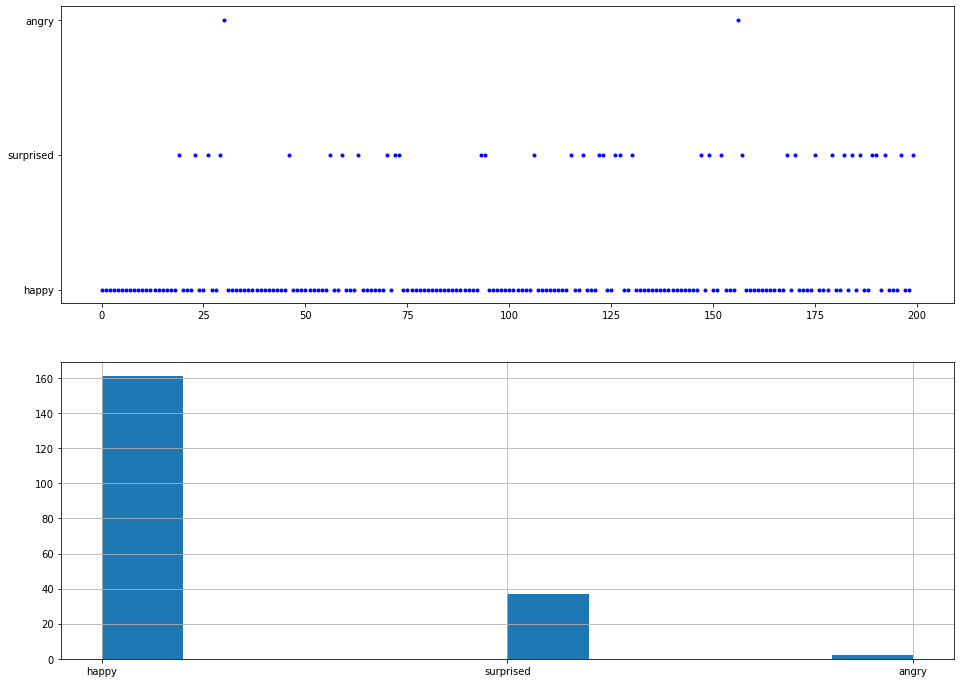

In [216]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize = (16,12))
plt.subplot(2,1,1)
plt.plot(np.array(df_emotions['emotion']), 'b.')
plt.subplot(2,1,2)
df_emotions['emotion'].hist()

In [210]:
df_emotions.where(df_emotions['emotion']=='happy').dropna()

,file_name,emotion,start_time,emotion_class,confidence
0,e_to_the_pi_i_for_dummies_v240P_0_3_audio.wav,happy,0,1,0.999986
111,e_to_the_pi_i_for_dummies_v240P_3_6_audio.wav,happy,3,1,0.999996
188,e_to_the_pi_i_for_dummies_v240P_6_9_audio.wav,happy,6,1,0.709440
199,e_to_the_pi_i_for_dummies_v240P_9_12_audio.wav,happy,9,1,0.918563
11,e_to_the_pi_i_for_dummies_v240P_12_15_audio.wav,happy,12,1,0.650562
...,...,...,...,...,...
176,e_to_the_pi_i_for_dummies_v240P_579_582_audio.wav,happy,579,1,0.771719
178,e_to_the_pi_i_for_dummies_v240P_582_585_audio.wav,happy,582,1,0.819926
179,e_to_the_pi_i_for_dummies_v240P_585_588_audio.wav,happy,585,1,0.918161
181,e_to_the_pi_i_for_dummies_v240P_591_594_audio.wav,happy,591,1,0.752411


### Save the model

In [40]:
tf.keras.models.save_model(model,"model")

INFO:tensorflow:Assets written to: model\assets
